In [1]:
# analysis of compiled radstats
# initial built: 2025/01/08
# tuned for paper: 2025/03/24
# analyze the model & obs cloud distributions

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [249]:
instrument = 'amsua'
channel    = 'ch5'

expid      = 'v3_hydro'
#expid       = 'old_CTRL_hydro'
#expid       = 'full_CTRL'
#expid       = 'full_CTRL_noinf'
#expid       = 'full_only_clr'
#expid      = 'full_clr_cld'
#expid       = 'full_sym'

stdev_from = f'OmF_{expid}'
predictor  = 'sym_cld'

sdate = '2024070500'
edate = '2024073012'

expid_short = {'full_clr_cld':    'clr & cld',
               'full_CTRL_noinf': 'CTRL (noinf)',
               'full_only_clr':   'clr',
               'full_CTRL':       'CTRL',
               'full_sym':        'sym cld',
               'full_sym_clwnbc': 'sym cld (noBC)',
               'old_CTRL_hydro':  'old-CTRL-hydro',
               'v3_hydro':        'v3_hydro'}

if instrument == 'amsua':
    if channel in ('ch1','ch3'):
        vmin = -30; vmax = 30;
    elif channel in ('ch2'):
        vmin = -45; vmax = 45;
    elif channel in ('ch4'):
        vmin = -7;  vmax = 7;
    elif channel in ('ch5'):
        vmin = -3;  vmax = 3;
    elif channel in ('ch15'):
        vmin = -40; vmax = 40;
            
elif instrument == 'atms':
    if channel in ('ch16'):
        vmin = -30; vmax = 30;
    elif channel in ('ch17','ch18'):
        vmin = -25; vmax = 25;
    elif channel in ('ch19','ch20'):
        vmin = -15; vmax = 15;
    elif channel in ('ch21','ch22'):
        vmin = -20; vmax = 20;
        
    

In [250]:
### read omf csv (large file!)
fn = f'/gpfs/f6/bil-coastal-gfdl/scratch/Chih-Chi.Hu/compile_radstats/csv_files/{expid}/omfges_stats_{instrument}_{channel}_{sdate}_{edate}.csv'
df = pd.read_csv(fn)

# screen the data:
dfs = df[abs(df['omf']) < 1e3]

In [251]:
### sort the data based on regions
regions=['sea']
lats   =['Global']

#regions=['land','sea']
#lats   =['Global','90S-60S','60S-40S','40S-20S','20S-0','0-20N','20N-40N','40N-60N','60N-90N']

adf={} # "a"nalysis "d"ata "f"rame

for rg in regions:
    adf[rg] = {}  # Initialize the nested dictionary for each experiment
    if rg == 'land':
        dftmp = dfs.loc[ dfs['fland']>=0.99 ]
    elif rg == 'sea':
        dftmp = dfs.loc[ dfs['fwater']>=0.99 ]
        
    for lat in lats:
        if lat == 'Global':
            adf[rg][lat] = dftmp
            #adf[rg][lat] = dftmp.loc[ dftmp['qcmark'] <= 3]

        elif lat == '90S-60S':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=-60) & (dftmp['lat']>-90) ]
        elif lat == '60S-40S':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=-40) & (dftmp['lat']>-60) ]
        elif lat == '40S-20S':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=-20) & (dftmp['lat']>-40) ]
        elif lat == '20S-0':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=0) & (dftmp['lat']>-20) ]
        elif lat == '0-20N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=20) & (dftmp['lat']>0) ]
        elif lat == '20N-40N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=40) & (dftmp['lat']>20) ]
        elif lat == '40N-60N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=60) & (dftmp['lat']>40) ]
        elif lat == '60N-90N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=90) & (dftmp['lat']>60) ]

In [252]:
dftmp = adf['sea']['Global']

In [253]:
dftmp['qcmark'].value_counts()

qcmark
0.0     635265
53.0     63410
3.0       1478
Name: count, dtype: int64

/tmp/ipykernel_1564946/2792696266.py:63: RuntimeWarning: divide by zero encountered in log10
  input_data = - np.log10(hist*dA)
/tmp/ipykernel_1564946/2792696266.py:72: RuntimeWarning: divide by zero encountered in log10
  contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)


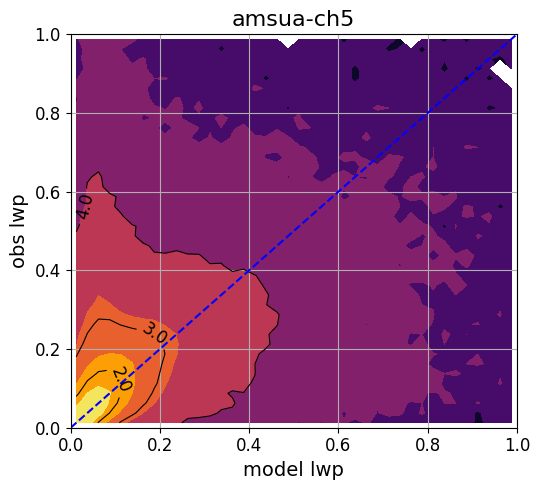

In [254]:
# model cloud vs observation cloud
# test different cloud proxy definitions:


save_fig = False
fig_dir = f'/gpfs/f6/bil-coastal-gfdl/scratch/Chih-Chi.Hu/python_codes/figures/model_obs_cloud_analysis/{expid}'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

cld_proxy = 'lwp'
#cld_proxy = 'lwp+si'
#cld_proxy = 'ch3'
#cld_proxy = 'si_ch1_ch15'
#cld_proxy = 'si_ch1_ch2_ch15'
#cld_proxy = 'si_ch16_ch17' 

if cld_proxy == 'lwp':
    x_edges = np.linspace( 0, 1, 41)  
    y_edges = np.linspace( 0, 1, 41)
    x = dftmp['clw_bg']; y = dftmp['clw_obs']
elif cld_proxy == 'cldeff':
    x_edges = np.linspace( -20, 20, 41)  
    y_edges = np.linspace( -20, 20, 41)
    x = dftmp['cldeff_bg']; y = dftmp['cldeff_obs']
elif cld_proxy == 'ch3':
    x_edges = np.linspace( 0, 30, 41)  
    y_edges = np.linspace( 0, 30, 41)
    x = dftmp['cld_ch3_bg']; y = dftmp['cld_ch3_obs']
elif cld_proxy == 'lwp+si':
    x_edges = np.linspace( 0, 1.2, 41)  
    y_edges = np.linspace( 0, 1.2, 41)
    x = dftmp['cld_lwpsi_bg']; y = dftmp['cld_lwpsi_obs']
elif cld_proxy == 'si_ch1_ch15':
    x_edges = np.linspace( 0, 30, 41)  
    y_edges = np.linspace( 0, 30, 41)
    x = dftmp['si_1_15_bg']; y = dftmp['si_1_15_obs']
elif cld_proxy == 'si_ch1_ch2_ch15':
    x_edges = np.linspace( 0, 30, 41)  
    y_edges = np.linspace( 0, 30, 41)
    x = dftmp['si_1_2_15_bg']; y = dftmp['si_1_2_15_obs']
elif cld_proxy == 'si_ch16_ch17':
    x_edges = np.linspace( 0, 40, 41)  
    y_edges = np.linspace( 0, 40, 41)
    x = dftmp['si_16_17_bg']; y = dftmp['si_16_17_obs']
else:
    raise ValueError(f" cloud proxy {cld_proxy} is incorrect!!!")  

    
dx = x_edges[1] - x_edges[0]
dy = y_edges[1] - y_edges[0]
dA = dx*dy

hist, x_edges_out, y_edges_out = np.histogram2d(x, y, bins=[x_edges, y_edges], density=True)

xc = 0.5*(x_edges[:-1] + x_edges[1:])
yc = 0.5*(y_edges[:-1] + y_edges[1:])

xx, yy = np.meshgrid(xc, yc)

# Mask values >= 6
input_data = - np.log10(hist*dA)
input_data_mask = np.ma.masked_where(input_data >= 5.5, input_data)
input_data_mask = input_data

## Plot figure
fig, ax = plt.subplots(figsize=(5.5,5))
contour1=ax.contourf(xx, yy, -input_data_mask.T, cmap='inferno')

# Add contour lines
contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)

# Add labels to contour lines
ax.clabel(contour_lines, inline=True, fontsize=12, fmt="%.1f")
ax.set_xlabel(f'model {cld_proxy}',fontsize=14)
ax.set_ylabel(f'obs {cld_proxy}',fontsize=14)
ax.plot([x_edges[0],x_edges[-1]], [x_edges[0],x_edges[-1]], linestyle='--', color='blue')
ax.set_xlim(x_edges[0], x_edges[-1])
ax.set_ylim(x_edges[0], x_edges[-1])

ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)
ax.set_title(f'{instrument}-{channel}',fontsize=16)
plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/jointpdf_model_obs_{cld_proxy}_{expid}.png', dpi=200, bbox_inches='tight')

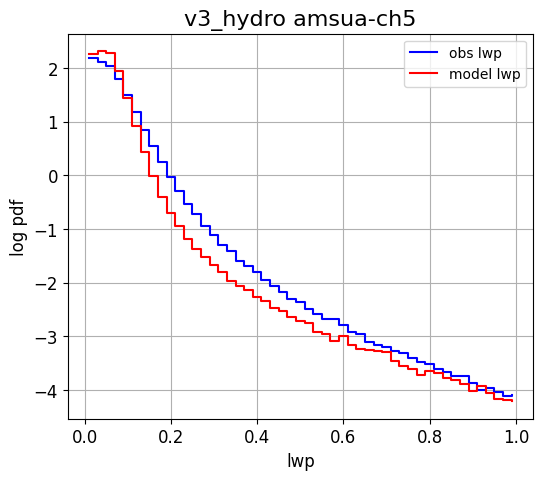

In [255]:
# check the marginal distribution of model & obs cloud proxy

#cld_proxy=

if cld_proxy == 'cldeff':
    dx = 0.1
    bin_max = 2
    bins = np.arange(-bin_max, bin_max+dx, dx)

    cld_obs_pdf, _  = np.histogram(dftmp['cldeff_obs'], bins=bins)
    cld_model_pdf, _ = np.histogram(dftmp['cldeff_bg'], bins=bins)
    #cld_model_pdf, _ = np.histogram(dftmp['cldeff_bg']+1.20*np.random.normal(loc=0, scale=1, size=len(dftmp['cldeff_bg'])), bins=bins)

elif cld_proxy == 'ch3':
    dx = 0.5
    bin_max = 30
    bins = np.arange(0, bin_max+dx, dx)
    
    cld_obs_pdf, _  = np.histogram(dftmp['cld_ch3_obs'], bins=bins)
    cld_model_pdf, _ = np.histogram(dftmp['cld_ch3_bg'], bins=bins)

elif cld_proxy == 'lwp':
    dx = 0.02
    bin_max = 1.0
    bins = np.arange(0, bin_max+dx, dx)
    cld_obs_pdf, _  = np.histogram(dftmp['clw_obs'], bins=bins)
    cld_model_pdf, _ = np.histogram(dftmp['clw_bg'], bins=bins)

elif cld_proxy == 'lwp+si':
    dx = 0.02
    bin_max = 1.2
    bins = np.arange(0, bin_max+dx, dx)
    cld_obs_pdf, _  = np.histogram(dftmp['cld_lwpsi_obs'], bins=bins)
    cld_model_pdf, _ = np.histogram(dftmp['cld_lwpsi_bg'], bins=bins)

elif cld_proxy == 'si_ch1_ch15':
    dx = 0.5
    bin_max = 20
    bins = np.arange(0, bin_max+dx, dx)
    cld_obs_pdf, _  = np.histogram(dftmp['si_1_15_obs'], bins=bins)
    cld_model_pdf, _ = np.histogram(dftmp['si_1_15_bg'], bins=bins)

elif cld_proxy == 'si_ch1_ch2_ch15':
    dx = 0.5
    bin_max = 20
    bins = np.arange(0, bin_max+dx, dx)
    cld_obs_pdf, _  = np.histogram(dftmp['si_1_2_15_obs'], bins=bins)
    cld_model_pdf, _ = np.histogram(dftmp['si_1_2_15_bg'], bins=bins)
    
elif cld_proxy == 'si_ch16_ch17':
    dx = 0.5
    bin_max = 20
    bins = np.arange(0, bin_max+dx, dx)
    cld_obs_pdf, _  = np.histogram(dftmp['si_16_17_obs'], bins=bins)
    cld_model_pdf, _ = np.histogram(dftmp['si_16_17_bg'], bins=bins)    
else:
    raise ValueError(f" cloud proxy {cld_proxy} is incorrect!!!")  

bin_center = 0.5*(bins[:-1]+bins[1:])

fig, ax = plt.subplots(figsize=(6,5))
ax.step(bin_center, np.log(cld_obs_pdf/sum(cld_obs_pdf)/dx),     where='post', linestyle='-', color='blue', label=f'obs {cld_proxy}')
ax.step(bin_center, np.log(cld_model_pdf/sum(cld_model_pdf)/dx),  where='post', linestyle='-', color='red', label=f'model {cld_proxy}')
ax.grid(True)
ax.set_xlabel(f'{cld_proxy}', fontsize=12)
ax.set_ylabel('log pdf', fontsize=12)
ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.legend()
ax.set_title(f'{expid_short[expid]} {instrument}-{channel}',fontsize=16)
if save_fig:
    plt.savefig(f'{fig_dir}/marginalpdf_model_obs_{cld_proxy}_{expid}.png', dpi=200, bbox_inches='tight')

In [256]:
# calculate the conditional mean omf/omfnbc for each model cloud vs observation cloud

#cld_proxy = 'cldeff' # clw, cldeff, ch3, lwpsi

cond_mean_omf    = np.zeros_like(xx) # the conditional mean omf
cond_mean_omf_norm_final = np.zeros_like(xx)

# generate the conditional mean omf in each (model cloud, obs cloud) box:
for ii in range(len(xc)):
    for jj in range(len(yc)):

        if cld_proxy == 'lwp':
            x_edges = np.linspace( 0, 1, 41)  
            y_edges = np.linspace( 0, 1, 41)
            dx = x_edges[1] - x_edges[0]
            dy = y_edges[1] - y_edges[0]
            dA = dx*dy
            
            xc = 0.5*(x_edges[:-1] + x_edges[1:])
            yc = 0.5*(y_edges[:-1] + y_edges[1:])
            xx, yy = np.meshgrid(xc, yc)
            
            cond_df = dftmp.loc[  (dftmp['clw_obs'] >= y_edges[jj]) \
                                & (dftmp['clw_obs'] <  y_edges[jj+1]) \
                                & (dftmp['clw_bg'] >= x_edges[ii]) \
                                & (dftmp['clw_bg'] <  x_edges[ii+1])]
            cond_mean_omf[ii,jj]    = np.nanmean(cond_df['omf'])
            cond_mean_omf_norm_final[ii,jj] = np.nanmean(cond_df['omf']*(cond_df['errinv']**2))

        elif cld_proxy == 'cldeff':
            x_edges = np.linspace( -2, 2, 41)  
            y_edges = np.linspace( -2, 2, 41)
            dx = x_edges[1] - x_edges[0]
            dy = y_edges[1] - y_edges[0]
            dA = dx*dy
            
            xc = 0.5*(x_edges[:-1] + x_edges[1:])
            yc = 0.5*(y_edges[:-1] + y_edges[1:])
            xx, yy = np.meshgrid(xc, yc)
            
            cond_df = dftmp.loc[  (dftmp['cldeff_obs'] >= y_edges[jj]) \
                                & (dftmp['cldeff_obs'] <  y_edges[jj+1]) \
                                & (dftmp['cldeff_bg'] >= x_edges[ii]) \
                                & (dftmp['cldeff_bg'] <  x_edges[ii+1])]
            cond_mean_omf[ii,jj]    = np.nanmean(cond_df['omf'])
            cond_mean_omf_norm_final[ii,jj] = np.nanmean(cond_df['omf']*(cond_df['errinv']**2))

        elif cld_proxy == 'ch3':
            x_edges = np.linspace( 0, 30, 41)  
            y_edges = np.linspace( 0, 30, 41)
            dx = x_edges[1] - x_edges[0]
            dy = y_edges[1] - y_edges[0]
            dA = dx*dy
            
            xc = 0.5*(x_edges[:-1] + x_edges[1:])
            yc = 0.5*(y_edges[:-1] + y_edges[1:])
            xx, yy = np.meshgrid(xc, yc)
            
            cond_df = dftmp.loc[  (dftmp['cld_ch3_obs'] >= y_edges[jj]) \
                                & (dftmp['cld_ch3_obs'] <  y_edges[jj+1]) \
                                & (dftmp['cld_ch3_bg'] >= x_edges[ii]) \
                                & (dftmp['cld_ch3_bg'] <  x_edges[ii+1])]
            cond_mean_omf[ii,jj]    = np.nanmean(cond_df['omf'])
            cond_mean_omf_norm_final[ii,jj] = np.nanmean(cond_df['omf']*(cond_df['errinv']**2))
            
        elif cld_proxy == 'lwp+si':
            x_edges = np.linspace( 0, 1.2, 41)  
            y_edges = np.linspace( 0, 1.2, 41)
            dx = x_edges[1] - x_edges[0]
            dy = y_edges[1] - y_edges[0]
            dA = dx*dy
            
            xc = 0.5*(x_edges[:-1] + x_edges[1:])
            yc = 0.5*(y_edges[:-1] + y_edges[1:])
            xx, yy = np.meshgrid(xc, yc)
            
            cond_df = dftmp.loc[  (dftmp['cld_lwpsi_obs'] >= y_edges[jj]) \
                                & (dftmp['cld_lwpsi_obs'] <  y_edges[jj+1]) \
                                & (dftmp['cld_lwpsi_bg'] >= x_edges[ii]) \
                                & (dftmp['cld_lwpsi_bg'] <  x_edges[ii+1])]
            cond_mean_omf[ii,jj]    = np.nanmean(cond_df['omf'])
            cond_mean_omf_norm_final[ii,jj] = np.nanmean(cond_df['omf']*(cond_df['errinv']**2))

        elif cld_proxy == 'si_ch1_ch15':
            x_edges = np.linspace( 0, 20, 41)  
            y_edges = np.linspace( 0, 20, 41)
            dx = x_edges[1] - x_edges[0]
            dy = y_edges[1] - y_edges[0]
            dA = dx*dy
            
            xc = 0.5*(x_edges[:-1] + x_edges[1:])
            yc = 0.5*(y_edges[:-1] + y_edges[1:])
            xx, yy = np.meshgrid(xc, yc)
            
            cond_df = dftmp.loc[  (dftmp['si_1_15_obs'] >= y_edges[jj]) \
                                & (dftmp['si_1_15_obs'] <  y_edges[jj+1]) \
                                & (dftmp['si_1_15_bg'] >= x_edges[ii]) \
                                & (dftmp['si_1_15_bg'] <  x_edges[ii+1])]
            cond_mean_omf[ii,jj]    = np.nanmean(cond_df['omf'])
            cond_mean_omf_norm_final[ii,jj] = np.nanmean(cond_df['omf']*(cond_df['errinv']**2))

        elif cld_proxy == 'si_ch1_ch2_ch15':
            x_edges = np.linspace( 0, 20, 41)  
            y_edges = np.linspace( 0, 20, 41)
            dx = x_edges[1] - x_edges[0]
            dy = y_edges[1] - y_edges[0]
            dA = dx*dy
            
            xc = 0.5*(x_edges[:-1] + x_edges[1:])
            yc = 0.5*(y_edges[:-1] + y_edges[1:])
            xx, yy = np.meshgrid(xc, yc)
            
            cond_df = dftmp.loc[  (dftmp['si_1_2_15_obs'] >= y_edges[jj]) \
                                & (dftmp['si_1_2_15_obs'] <  y_edges[jj+1]) \
                                & (dftmp['si_1_2_15_bg'] >= x_edges[ii]) \
                                & (dftmp['si_1_2_15_bg'] <  x_edges[ii+1])]
            cond_mean_omf[ii,jj]    = np.nanmean(cond_df['omf'])
            cond_mean_omf_norm_final[ii,jj] = np.nanmean(cond_df['omf']*(cond_df['errinv']**2))

        elif cld_proxy == 'si_ch16_ch17':
            x_edges = np.linspace( 0, 40, 41)  
            y_edges = np.linspace( 0, 40, 41)
            dx = x_edges[1] - x_edges[0]
            dy = y_edges[1] - y_edges[0]
            dA = dx*dy
            
            xc = 0.5*(x_edges[:-1] + x_edges[1:])
            yc = 0.5*(y_edges[:-1] + y_edges[1:])
            xx, yy = np.meshgrid(xc, yc)
            
            cond_df = dftmp.loc[  (dftmp['si_16_17_obs'] >= y_edges[jj]) \
                                & (dftmp['si_16_17_obs'] <  y_edges[jj+1]) \
                                & (dftmp['si_16_17_bg'] >= x_edges[ii]) \
                                & (dftmp['si_16_17_bg'] <  x_edges[ii+1])]
            cond_mean_omf[ii,jj]    = np.nanmean(cond_df['omf'])
            cond_mean_omf_norm_final[ii,jj] = np.nanmean(cond_df['omf']*(cond_df['errinv']**2))

/tmp/ipykernel_1564946/459087228.py:27: RuntimeWarning: Mean of empty slice
  cond_mean_omf[ii,jj]    = np.nanmean(cond_df['omf'])
/tmp/ipykernel_1564946/459087228.py:28: RuntimeWarning: Mean of empty slice
  cond_mean_omf_norm_final[ii,jj] = np.nanmean(cond_df['omf']*(cond_df['errinv']**2))


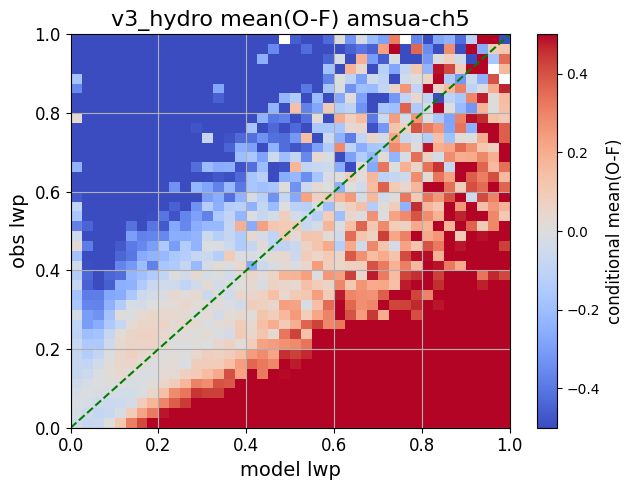

In [257]:
# Plot the conditional mean omf/omfnbc for each model cloud vs observation cloud

save_fig = True
fig_dir = f'/gpfs/f6/bil-coastal-gfdl/scratch/Chih-Chi.Hu/python_codes/figures/model_obs_cloud_analysis/{expid}'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

if instrument =='amsua':
    if channel in ('ch1','ch3','ch15'):
        vmax = 15; 
    elif channel in ('ch2'):
        vmax = 30; 
    elif channel in ('ch4'):
        vmax = 2.5;
    elif channel in ('ch5'):
        #vmax = 1
        vmax = 0.5
elif instrument=='atms':
    if channel in ('ch1','ch3'):
        vmax = 15; 
    elif channel in ('ch2'):
        vmax = 30; 
    elif channel in ('ch4'):
        vmax = 8; 
    elif channel in ('ch5'):
        vmax = 2.5;
    elif channel in ('ch6'):
        vmax = 1
    if channel in ('ch16','N/A'):
        vmax = 20
    elif channel in ('ch17','N/A'):
        vmax = 15
    elif channel in ('ch18','N/A'):
        vmax = 12
    elif channel in ('ch19','N/A'):
        vmax = 7
    elif channel in ('ch20','ch21','ch22'):
        vmax = 3

vmin=-vmax

## Plot figure
fig, ax = plt.subplots(figsize=(6.5,5))
contour1=ax.pcolormesh(xx, yy, cond_mean_omf.T, cmap='coolwarm', shading='auto', vmin=vmin, vmax=vmax)

# Add the colorbar
cbar = fig.colorbar(contour1, ax=ax)
cbar.set_label('conditional mean(O-F)', fontsize=12)
ax.set_xlabel(f'model {cld_proxy}',fontsize=14)
ax.set_ylabel(f'obs {cld_proxy}',fontsize=14)

ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)
ax.plot([x_edges[0], x_edges[-1]], [x_edges[0], x_edges[-1]], linestyle='--',color='green')
ax.set_title(f'{expid_short[expid]} mean(O-F) {instrument}-{channel}',fontsize=16)
#ax.set_title(f'{expid_short[expid]} mean(O-F) {instrument}-{channel} w/o deep convection',fontsize=16)

plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/cond_mean_omf_{cld_proxy}_{instrument}_{channel}_{expid}.png', dpi=200, bbox_inches='tight')
    #plt.savefig(f'{fig_dir}/cond_mean_omf_{cld_proxy}_{instrument}_{channel}_{expid}_no_convection.png', dpi=200, bbox_inches='tight')


In [348]:
vmin

-7

/tmp/ipykernel_2754283/3562681734.py:77: RuntimeWarning: divide by zero encountered in log10
  contour_lines = ax.contour(xx, yy, -np.log10(hist*dA).T, levels=[2.5,3.5,4.5], colors=(1,1,1), linewidths=7)


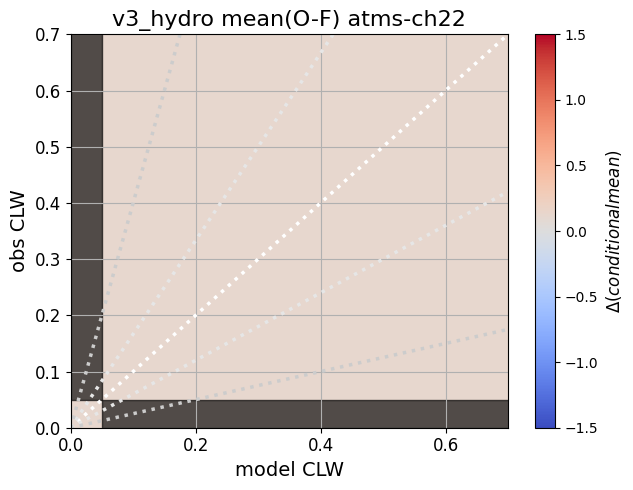

In [285]:
# Plot the conditional mean omf/omfnbc for each model cloud vs observation cloud (with PDF)

save_fig = False
fig_dir = f'/gpfs/f6/bil-coastal-gfdl/scratch/Chih-Chi.Hu/python_codes/figures/model_obs_cloud_analysis/{expid}'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

if instrument =='amsua':
    if channel in ('ch1','ch3','ch15'):
        vmax = 15; 
    elif channel in ('ch2'):
        vmax = 30; 
    elif channel in ('ch4'):
        vmax = 2.5;
    elif channel in ('ch5'):
        vmax = 1
elif instrument=='atms':
    if channel in ('ch1','ch3'):
        vmax = 15; 
    elif channel in ('ch2'):
        vmax = 30; 
    elif channel in ('ch4'):
        vmax = 8; 
    elif channel in ('ch5'):
        vmax = 2.5;
    elif channel in ('ch6'):
        vmax = 1
    if channel in ('ch16'):
        vmax = 20
    elif channel in ('ch17'):
        vmax = 15
    elif channel in ('ch18','ch19'):
        vmax = 3
    elif channel in ('ch20','ch21','ch22'):
        vmax = 1.5
vmin = -vmax

## Plot figure
fig, ax = plt.subplots(figsize=(6.5,5))
contour1=ax.pcolormesh(xx, yy, cond_mean_omf.T, cmap='coolwarm', shading='auto', vmin=vmin, vmax=vmax)
#contour1=ax.pcolormesh(xx, yy, cond_mean_omf_norm_sym.T - cond_mean_omf_norm_final.T, cmap='coolwarm', shading='auto', vmin=vmin, vmax=vmax)
#contour1=ax.pcolormesh(xx, yy, cond_mean_omf_norm_sym.T, cmap='RdBu_r', shading='auto', vmin=vmin, vmax=vmax)

# Add the colorbar
cbar = fig.colorbar(contour1, ax=ax)
cbar.set_label(r'$\Delta(conditional mean)$', fontsize=12)

ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlabel('model CLW',fontsize=14)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_ylabel(f'obs CLW',fontsize=14)

#ax.axhline(0.05, linewidth=2, color='black')
#ax.axvline(0.05, linewidth=2, color='black')

width_help_lines = 2.5
ax.plot([0,1], [0,1],      linestyle=':',  color=(1,1,1), linewidth=width_help_lines)
ax.plot([0,1], [0,0.6],    linestyle=':',  color=(0.9,0.9,0.9), linewidth=width_help_lines)
ax.plot([0,1], [0,0.25],   linestyle=':',  color=(0.8,0.8,0.8), linewidth=width_help_lines)
ax.plot([0,1], [0,1/0.6],  linestyle=':',  color=(0.9,0.9,0.9), linewidth=width_help_lines)
ax.plot([0,1], [0,1/0.25], linestyle=':',  color=(0.8,0.8,0.8), linewidth=width_help_lines)

if instrument == 'atms':
    ax.set_xlim([0,0.7])
    ax.set_ylim([0,0.7])
else:
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)

# Add contour lines
contour_lines = ax.contour(xx, yy, -np.log10(hist*dA).T, levels=[2.5,3.5,4.5], colors=(1,1,1), linewidths=7)

# Add shaded region:
ax.fill([0.05, 0.05, 1.00, 1.00],   # X-coordinates of the rectangle
        [0.00, 0.05, 0.05, 0.00],   # Y-coordinates of the rectangle
        color='black', alpha=0.65)  # Fill color and transparency

ax.fill([0.00, 0.05, 0.05, 0.00],   # X-coordinates of the rectangle
        [0.05, 0.05, 1.00, 1.00],   # Y-coordinates of the rectangle
        color='black', alpha=0.65)  # Fill color and transparency


ax.set_title(f'{expid_short[expid]} mean(O-F) {instrument}-{channel}',fontsize=16)
plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/cond_mean_omf_withpdf_{instrument}_{channel}_{expid}.png', dpi=200, bbox_inches='tight')


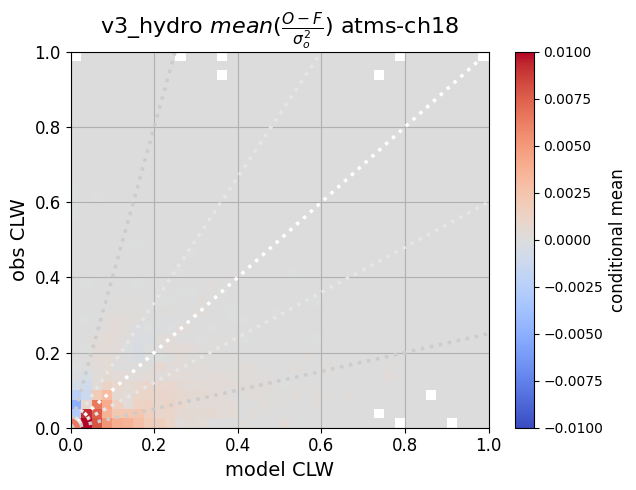

In [270]:
# Plot the conditional mean omf/R for each model cloud vs observation cloud (without PDF)

save_fig = False
fig_dir = f'/gpfs/f6/bil-coastal-gfdl/scratch/Chih-Chi.Hu/python_codes/figures/model_obs_cloud_analysis/{expid}'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

if 'noinf' in expid:
    if channel in ('ch4'):
        vmax = 1.2
    elif channel in ('ch5'):
        vmax = 2
    elif channel in ('ch15'):
        vmax = 0.15
    else:
        vmax = 0.25
else:
    if channel in ('ch4','ch5'):
        vmax = 0.2
    else:
        vmax = 0.03

vmax = 0.01
vmin = -vmax

## Plot figure
fig, ax = plt.subplots(figsize=(6.5,5))
contour1=ax.pcolormesh(xx, yy, cond_mean_omf_norm_final.T, cmap='coolwarm', shading='auto', vmin=vmin, vmax=vmax)
#contour1=ax.pcolormesh(xx, yy, cond_mean_omf_norm_sym.T, cmap='RdBu_r', shading='auto', vmin=vmin, vmax=vmax)

# Add the colorbar
cbar = fig.colorbar(contour1, ax=ax)
cbar.set_label(r'conditional mean', fontsize=12)

ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlabel('model CLW',fontsize=14)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_ylabel(f'obs CLW',fontsize=14)

width_help_lines = 2.5
ax.plot([0,1], [0,1],      linestyle=':',  color=(1,1,1), linewidth=width_help_lines)
ax.plot([0,1], [0,0.6],    linestyle=':',  color=(0.9,0.9,0.9), linewidth=width_help_lines)
ax.plot([0,1], [0,0.25],   linestyle=':',  color=(0.8,0.8,0.8), linewidth=width_help_lines)
ax.plot([0,1], [0,1/0.6],  linestyle=':',  color=(0.9,0.9,0.9), linewidth=width_help_lines)
ax.plot([0,1], [0,1/0.25], linestyle=':',  color=(0.8,0.8,0.8), linewidth=width_help_lines)

'''
if instrument == 'atms':
    ax.set_xlim([0,0.7])
    ax.set_ylim([0,0.7])
else:
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
'''

ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)
ax.set_title(rf"{expid_short[expid]} $mean(\frac{{O-F}}{{\sigma_o^2}})$ {instrument}-{channel}",fontsize=16)
plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/cond_mean_omf_norm_{instrument}_{channel}_{expid}.png', dpi=200, bbox_inches='tight')

/tmp/ipykernel_1096305/274418185.py:77: RuntimeWarning: divide by zero encountered in log10
  contour_lines = ax.contour(xx, yy, -np.log10(hist*dA).T, levels=[2.5,3.5,4.5,5.5], colors=(1,1,1), linewidths=7)


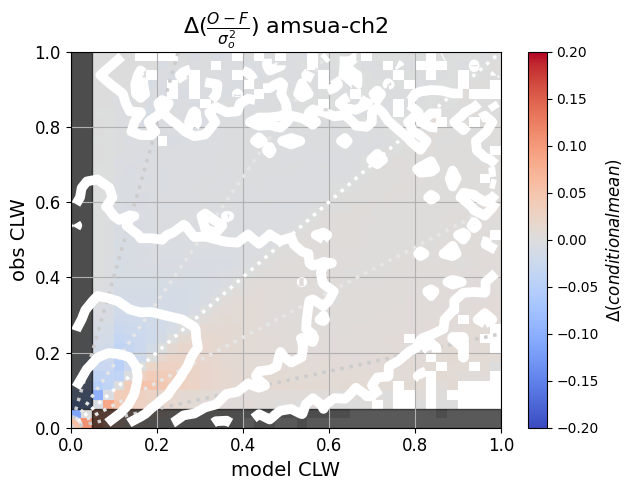

In [24]:
# Plot the difference of conditional mean omf/R for each model cloud vs observation cloud (without PDF)
#          (due to empirical inflation)

save_fig = True
fig_dir = f'/gpfs/f6/bil-coastal-gfdl/scratch/Chih-Chi.Hu/python_codes/figures/model_obs_cloud_analysis/{expid}'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

if instrument =='amsua':
    if channel in ('ch1','ch3','ch15'):
        vmax = 0.2; 
    elif channel in ('ch2'):
        vmax = 0.2; 
    elif channel in ('ch4'):
        vmax = 1.5;
    elif channel in ('ch5'):
        vmax = 1.5;
elif instrument=='atms':
    if channel in ('ch1','ch3'):
        vmax = 15; 
    elif channel in ('ch2'):
        vmax = 30; 
    elif channel in ('ch4'):
        vmax = 8; 
    elif channel in ('ch5'):
        vmax = 2.5;
    elif channel in ('ch6'):
        vmax = 1
    if channel in ('ch16'):
        vmax = 0.2
    elif channel in ('ch17'):
        vmax = 0.2
    elif channel in ('ch18','ch19'):
        vmax = 0.5
    elif channel in ('ch20','ch21','ch22'):
        vmax = 0.2
vmin = -vmax

## Plot figure
fig, ax = plt.subplots(figsize=(6.5,5))
contour1=ax.pcolormesh(xx, yy, cond_mean_omf_norm_sym.T - cond_mean_omf_norm_final.T, cmap='coolwarm', shading='auto', vmin=vmin, vmax=vmax)
#contour1=ax.pcolormesh(xx, yy, cond_mean_omf_norm_sym.T, cmap='RdBu_r', shading='auto', vmin=vmin, vmax=vmax)

# Add the colorbar
cbar = fig.colorbar(contour1, ax=ax)
cbar.set_label(r'$\Delta(conditional mean)$', fontsize=12)

ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlabel('model CLW',fontsize=14)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_ylabel(f'obs CLW',fontsize=14)

#ax.axhline(0.05, linewidth=2, color='black')
#ax.axvline(0.05, linewidth=2, color='black')

width_help_lines = 2.5
ax.plot([0,1], [0,1],      linestyle=':',  color=(1,1,1), linewidth=width_help_lines)
ax.plot([0,1], [0,0.6],    linestyle=':',  color=(0.9,0.9,0.9), linewidth=width_help_lines)
ax.plot([0,1], [0,0.25],   linestyle=':',  color=(0.8,0.8,0.8), linewidth=width_help_lines)
ax.plot([0,1], [0,1/0.6],  linestyle=':',  color=(0.9,0.9,0.9), linewidth=width_help_lines)
ax.plot([0,1], [0,1/0.25], linestyle=':',  color=(0.8,0.8,0.8), linewidth=width_help_lines)

if instrument == 'atms':
    ax.set_xlim([0,0.7])
    ax.set_ylim([0,0.7])
else:
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)

# Add contour lines
contour_lines = ax.contour(xx, yy, -np.log10(hist*dA).T, levels=[2.5,3.5,4.5,5.5], colors=(1,1,1), linewidths=7)

# Add shaded region:
ax.fill([0.05, 0.05, 1.00, 1.00],   # X-coordinates of the rectangle
        [0.00, 0.05, 0.05, 0.00],   # Y-coordinates of the rectangle
        color='black', alpha=0.65)  # Fill color and transparency

ax.fill([0.00, 0.05, 0.05, 0.00],   # X-coordinates of the rectangle
        [0.05, 0.05, 1.00, 1.00],   # Y-coordinates of the rectangle
        color='black', alpha=0.65)  # Fill color and transparency


ax.set_title(rf"$\Delta (\frac{{O-F}}{{\sigma_o^2}})$ {instrument}-{channel}",fontsize=16)
plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/cond_mean_diff_no_infla_omf_norm_{instrument}_{channel}_{expid}.png', dpi=200, bbox_inches='tight')

/tmp/ipykernel_2580992/1521298478.py:50: RuntimeWarning: divide by zero encountered in log10
  contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2.5,3.5,4.5,5.5], colors='white', linewidths=4)


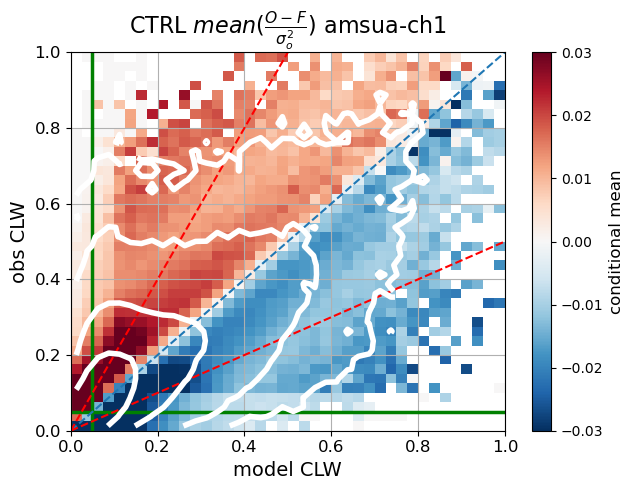

In [11]:
# Plot the conditional mean omf/R for each model cloud vs observation cloud (with PDF)

save_fig = False
fig_dir = f'/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/python_codes/figures/model_obs_cloud_analysis/{expid}'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

if 'noinf' in expid:
    if channel in ('ch4'):
        vmax = 1.2
    elif channel in ('ch5'):
        vmax = 2
    elif channel in ('ch15'):
        vmax = 0.15
    else:
        vmax = 0.25
else:
    if channel in ('ch4','ch5'):
        vmax = 0.2
    else:
        vmax = 0.03
vmin = -vmax

## Plot figure
fig, ax = plt.subplots(figsize=(6.5,5))
contour1=ax.pcolormesh(xx, yy, cond_mean_omf_norm_final.T, cmap='RdBu_r', shading='auto', vmin=vmin, vmax=vmax)

# Add the colorbar
cbar = fig.colorbar(contour1, ax=ax)
cbar.set_label(r'conditional mean', fontsize=12)

ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlabel('model CLW',fontsize=14)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_ylabel(f'obs CLW',fontsize=14)

ax.axvline(0.05, color='green', linewidth=2.5)
ax.axhline(0.05, color='green', linewidth=2.5)

ax.plot([0,1], [0,1], linestyle='--')
ax.plot([0,1], [0,0.5], linestyle='--', color='red')
ax.plot([0,1], [0,2], linestyle='--', color='red')

ax.set_xlim([0,1])
ax.set_ylim([0,1])

# Add contour lines
contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2.5,3.5,4.5,5.5], colors='white', linewidths=4)

# Add labels to contour lines
#ax.clabel(contour_lines, inline=True, fontsize=14, fmt="%.1f")

ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)
ax.set_title(rf"{expid_short[expid]} $mean(\frac{{O-F}}{{\sigma_o^2}})$ {instrument}-{channel}",fontsize=16)
plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/cond_mean_omf_norm_withpdf_{instrument}_{channel}_{expid}.png', dpi=200, bbox_inches='tight')

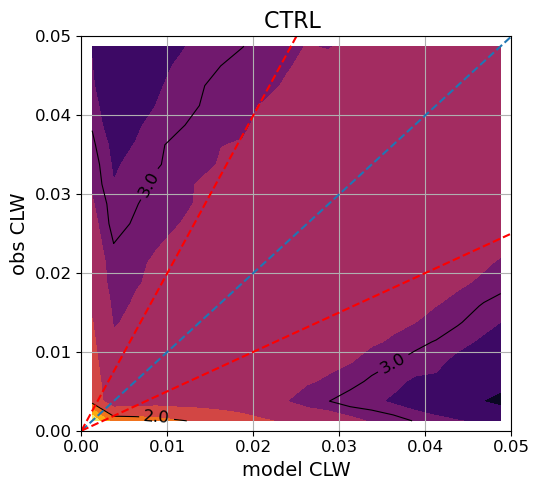

In [58]:
# model cloud vs observation cloud
# symmetric cloud vs OmF cloud (clr-clr)

save_fig = False
fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/model_obs_cloud_analysis/{expid}'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

x_edges = np.linspace( 0, 0.05, 21)  
y_edges = np.linspace( 0, 0.05, 21)
dx = x_edges[1] - x_edges[0]
dy = y_edges[1] - y_edges[0]
dA_clr_clr = dx*dy

x = dftmp['clw_bg_nobc_ges']
y = dftmp['clw_obs'] 

hist_clr_clr, x_edges_out, y_edges_out = np.histogram2d(x, y, bins=[x_edges, y_edges], density=True)

xc = 0.5*(x_edges[:-1] + x_edges[1:])
yc = 0.5*(y_edges[:-1] + y_edges[1:])

xx, yy = np.meshgrid(xc, yc)

# Mask values >= 6
input_data = - np.log10(hist_clr_clr*dA)
input_data_mask = np.ma.masked_where(input_data >= 5.5, input_data)
input_data_mask = input_data

## Plot figure
fig, ax = plt.subplots(figsize=(5.5,5))
contour1=ax.contourf(xx, yy, -input_data_mask.T, cmap='inferno')

# Add contour lines
contour_lines = plt.contour(xx, yy, -np.log10(hist_clr_clr*dA_clr_clr).T, levels=[2,3,4], colors='black', linewidths=0.8)

# Add labels to contour lines
ax.clabel(contour_lines, inline=True, fontsize=12, fmt="%.1f")

ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlabel('model CLW',fontsize=14)
#ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_ylabel(f'obs CLW',fontsize=14)

#ax.axvline(0.05, color='green')
#ax.axhline(0.05, color='green')

ax.plot([0,1], [0,1], linestyle='--')
ax.plot([0,1], [0,0.5], linestyle='--', color='red')
ax.plot([0,1], [0,2], linestyle='--', color='red')

ax.set_xlim([0,0.05])
ax.set_ylim([0,0.05])

ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)
ax.set_title(f'{expid_short[expid]} ',fontsize=16)
plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/jointpdf_clr_clr_model_obs_cloud_{expid}.png', dpi=200, bbox_inches='tight')

In [70]:
# calculate the conditional mean omf/omfnbc for clr/clr boxes

x_edges = np.linspace( 0, 0.05, 21)  
y_edges = np.linspace( 0, 0.05, 21)
dx = x_edges[1] - x_edges[0]
dy = y_edges[1] - y_edges[0]
dA_clr_clr = dx*dy

xc = 0.5*(x_edges[:-1] + x_edges[1:])
yc = 0.5*(y_edges[:-1] + y_edges[1:])

xx, yy = np.meshgrid(xc, yc)

cond_mean_omf_clr_clr            = np.zeros_like(xx) # the conditional mean omf
cond_mean_omf_norm_sym_clr_clr   = np.zeros_like(xx)
cond_mean_omf_norm_final_clr_clr = np.zeros_like(xx)

# generate the conditional mean omf in each (model cloud, obs cloud) box:
for ii in range(len(xc)):
    for jj in range(len(yc)):
        cond_df = dftmp.loc[  (dftmp['clw_obs'] >= y_edges[jj]) \
                            & (dftmp['clw_obs'] <  y_edges[jj+1]) \
                            & (dftmp['clw_bg_nobc_ges'] >= x_edges[ii]) \
                            & (dftmp['clw_bg_nobc_ges'] <  x_edges[ii+1])]
        cond_mean_omf_clr_clr[ii,jj]    = np.nanmean(cond_df['omf_ges'])
        cond_mean_omf_norm_sym_clr_clr[ii,jj]   = np.nanmean(cond_df['omf_ges']/(cond_df['symerr_ges']**2))
        cond_mean_omf_norm_final_clr_clr[ii,jj] = np.nanmean(cond_df['omf_ges']*(cond_df['errinv_ges']**2))

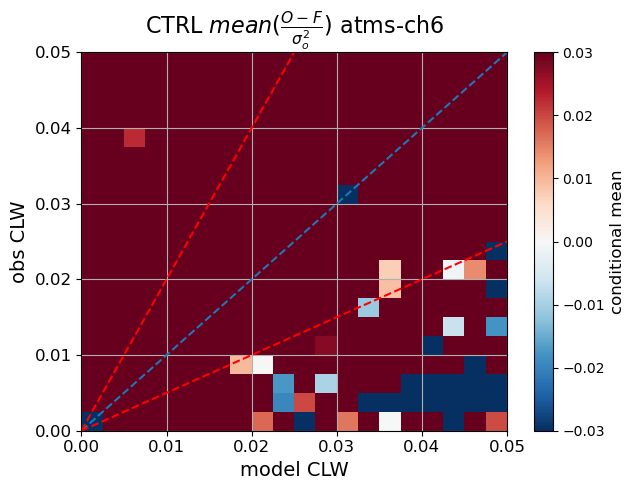

In [71]:
# Plot the conditional mean omf/R for each model cloud vs observation cloud (without PDF)

save_fig = True
fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/model_obs_cloud_analysis/{expid}'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

if 'noinf' in expid:
    if channel in ('ch4'):
        vmax = 1.2
    elif channel in ('ch5'):
        vmax = 1
    elif channel in ('ch15'):
        vmax = 0.2
    else:
        vmax = 0.25
else:
    if channel in ('ch4','ch5'):
        vmax = 0.5
    else:
        vmax = 0.03
vmin = -vmax

## Plot figure
fig, ax = plt.subplots(figsize=(6.5,5))
contour1=ax.pcolormesh(xx, yy, cond_mean_omf_norm_final_clr_clr.T, cmap='RdBu_r', shading='auto', vmin=vmin, vmax=vmax)

# Add the colorbar
cbar = fig.colorbar(contour1, ax=ax)
cbar.set_label(r'conditional mean', fontsize=12)
ax.set_xlabel('model CLW',fontsize=14)
ax.set_ylabel(f'obs CLW',fontsize=14)

ax.plot([0,1], [0,1], linestyle='--')
ax.plot([0,1], [0,0.5], linestyle='--', color='red')
ax.plot([0,1], [0,2], linestyle='--', color='red')

ax.set_xlim([0,0.05])
ax.set_ylim([0,0.05])

ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)
ax.set_title(rf"{expid_short[expid]} $mean(\frac{{O-F}}{{\sigma_o^2}})$ {instrument}-{channel}",fontsize=16)
plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/cond_mean_clr_clr_omf_norm_{instrument}_{channel}_{expid}.png', dpi=200, bbox_inches='tight')


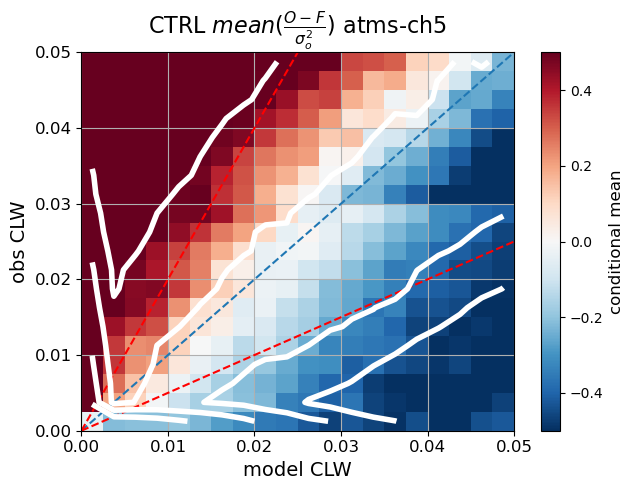

In [61]:
# Plot the conditional mean omf/R for each model cloud vs observation cloud (with PDF)

save_fig = True
fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/model_obs_cloud_analysis/{expid}'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

if 'noinf' in expid:
    if channel in ('ch4'):
        vmax = 1.2
    elif channel in ('ch5'):
        vmax = 1
    elif channel in ('ch15'):
        vmax = 0.2
    else:
        vmax = 0.25
else:
    if channel in ('ch4','ch5'):
        vmax = 0.5
    else:
        vmax = 0.03
vmin = -vmax

## Plot figure
fig, ax = plt.subplots(figsize=(6.5,5))
contour1=ax.pcolormesh(xx, yy, cond_mean_omf_norm_final_clr_clr.T, cmap='RdBu_r', shading='auto', vmin=vmin, vmax=vmax)

# Add the colorbar
cbar = fig.colorbar(contour1, ax=ax)
cbar.set_label(r'conditional mean', fontsize=12)
ax.set_xlabel('model CLW',fontsize=14)
ax.set_ylabel(f'obs CLW',fontsize=14)

ax.plot([0,1], [0,1], linestyle='--')
ax.plot([0,1], [0,0.5], linestyle='--', color='red')
ax.plot([0,1], [0,2], linestyle='--', color='red')

ax.set_xlim([0,0.05])
ax.set_ylim([0,0.05])

# Add contour lines
contour_lines = plt.contour(xx, yy, -np.log10(hist_clr_clr*dA_clr_clr).T, levels=[2, 2.3, 2.6, 2.9], colors='white', linewidths=4)

ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)
ax.set_title(rf"{expid_short[expid]} $mean(\frac{{O-F}}{{\sigma_o^2}})$ {instrument}-{channel}",fontsize=16)
plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/cond_mean_clr_clr_omf_norm_withpdf_{instrument}_{channel}_{expid}.png', dpi=200, bbox_inches='tight')


/tmp/ipykernel_3763674/603848156.py:28: RuntimeWarning: divide by zero encountered in log10
  input_data = - np.log10(hist*dA)
/tmp/ipykernel_3763674/603848156.py:37: RuntimeWarning: divide by zero encountered in log10
  contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)


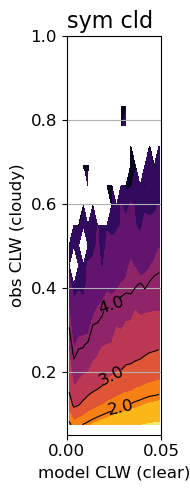

In [88]:
# model cloud vs observation cloud
# symmetric cloud vs OmF cloud (cloud mismatch)

save_fig = True
fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/model_obs_cloud_analysis/{expid}'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

x_edges = np.linspace(   0, 0.05, 21)  
y_edges = np.linspace( 0.05, 1,   21)
dx = x_edges[1] - x_edges[0]
dy = y_edges[1] - y_edges[0]
dA = dx*dy

x = dftmp['clw_bg_nobc_ges']
y = dftmp['clw_obs'] 

hist, x_edges_out, y_edges_out = np.histogram2d(x, y, bins=[x_edges, y_edges], density=True)

xc = 0.5*(x_edges[:-1] + x_edges[1:])
yc = 0.5*(y_edges[:-1] + y_edges[1:])

xx, yy = np.meshgrid(xc, yc)

# Mask values >= 6
input_data = - np.log10(hist*dA)
input_data_mask = np.ma.masked_where(input_data >= 5.5, input_data)
input_data_mask = input_data

## Plot figure
fig, ax = plt.subplots(figsize=(2,5))
contour1=ax.contourf(xx, yy, -input_data_mask.T, cmap='inferno')

# Add contour lines
contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)

# Add labels to contour lines
ax.clabel(contour_lines, inline=True, fontsize=12, fmt="%.1f")

ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlabel('model CLW (clear)',fontsize=12)
ax.set_xticks([0, 0.05])
ax.set_ylabel(f'obs CLW (cloudy)',fontsize=12)

#ax.axvline(0.05, color='green')
#ax.axhline(0.05, color='green')

#ax.plot([0,1], [0,1], linestyle='--')
#ax.plot([0,1], [0,0.5], linestyle='--', color='red')
#ax.plot([0,1], [0,2], linestyle='--', color='red')

ax.set_xlim([0,0.05])
ax.set_ylim([0.05,1.0])

ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)
ax.set_title(f'{expid_short[expid]} ',fontsize=16)
plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/jointpdf_mismatch_clr_cld_model_obs_cloud_{expid}.png', dpi=200, bbox_inches='tight')

/tmp/ipykernel_3763674/4032353471.py:28: RuntimeWarning: divide by zero encountered in log10
  input_data = - np.log10(hist*dA)
/tmp/ipykernel_3763674/4032353471.py:37: RuntimeWarning: divide by zero encountered in log10
  contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)


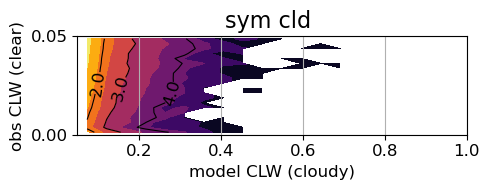

In [89]:
# model cloud vs observation cloud
# symmetric cloud vs OmF cloud (cloud mismatch)

save_fig = True
fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/model_obs_cloud_analysis/{expid}'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

x_edges = np.linspace( 0.05, 1, 21)  
y_edges = np.linspace( 0, 0.05, 21)
dx = x_edges[1] - x_edges[0]
dy = y_edges[1] - y_edges[0]
dA = dx*dy

x = dftmp['clw_bg_nobc_ges']
y = dftmp['clw_obs'] 

hist, x_edges_out, y_edges_out = np.histogram2d(x, y, bins=[x_edges, y_edges], density=True)

xc = 0.5*(x_edges[:-1] + x_edges[1:])
yc = 0.5*(y_edges[:-1] + y_edges[1:])

xx, yy = np.meshgrid(xc, yc)

# Mask values >= 6
input_data = - np.log10(hist*dA)
input_data_mask = np.ma.masked_where(input_data >= 5.5, input_data)
input_data_mask = input_data

## Plot figure
fig, ax = plt.subplots(figsize=(5,2))
contour1=ax.contourf(xx, yy, -input_data_mask.T, cmap='inferno')

# Add contour lines
contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)

# Add labels to contour lines
ax.clabel(contour_lines, inline=True, fontsize=12, fmt="%.1f")

ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlabel('model CLW (cloudy)',fontsize=12)
ax.set_yticks([0, 0.05])
ax.set_ylabel(f'obs CLW (clear)',fontsize=12)

#ax.axvline(0.05, color='green')
#ax.axhline(0.05, color='green')

#ax.plot([0,1], [0,1], linestyle='--')
#ax.plot([0,1], [0,0.5], linestyle='--', color='red')
#ax.plot([0,1], [0,2], linestyle='--', color='red')

ax.set_xlim([0.05,1.0])
ax.set_ylim([0,0.05])

ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)
ax.set_title(f'{expid_short[expid]} ',fontsize=16)
plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/jointpdf_mismatch_cld_clr_model_obs_cloud_{expid}.png', dpi=200, bbox_inches='tight')

/tmp/ipykernel_3763674/2967055653.py:39: RuntimeWarning: divide by zero encountered in log10
  input_data = - np.log10(hist*dA)
/tmp/ipykernel_3763674/2967055653.py:48: RuntimeWarning: divide by zero encountered in log10
  contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)


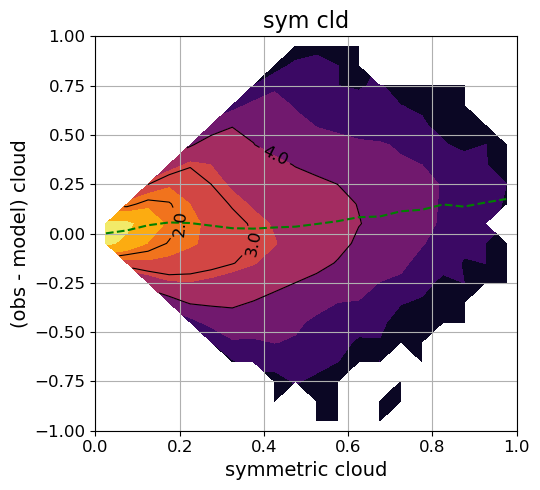

In [90]:
# symmetric cloud vs OmF cloud

save_fig = True
fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/model_obs_cloud_analysis/{expid}'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

sym_cloud = 0.5*(dftmp['clw_bg_nobc_ges'] + dftmp['clw_obs'])

x = sym_cloud
y = dftmp['clw_obs'] - dftmp['clw_bg_nobc_ges']

# calculate the conditional mean (takes time...)
xx = np.linspace(0,1,21)
xxc = 0.5*(xx[:-1] + xx[1:])
yyc = np.zeros_like(xxc)
for i in range(len(xxc)):
    xdftmp = dftmp.loc[ (sym_cloud>=xx[i]) & (sym_cloud<xx[i+1]) ]
    yyc[i] = xdftmp['clw_obs'].mean() - xdftmp['clw_bg_nobc_ges'].mean()
    
    
# joint pdf:
x_edges = np.linspace( 0, 1, 21)  
y_edges = np.linspace(-1, 1, 21)
dx = x_edges[1] - x_edges[0]
dy = y_edges[1] - y_edges[0]
dA = dx*dy

hist, x_edges_out, y_edges_out = np.histogram2d(x, y, bins=[x_edges, y_edges], density=True)

xc = 0.5*(x_edges[:-1] + x_edges[1:])
yc = 0.5*(y_edges[:-1] + y_edges[1:])

xx, yy = np.meshgrid(xc, yc)

# Mask values >= 6
input_data = - np.log10(hist*dA)
input_data_mask = np.ma.masked_where(input_data >= 5.5, input_data)
input_data_mask = input_data

## Plot figure
fig, ax = plt.subplots(figsize=(5.5,5))
contour1=ax.contourf(xx, yy, -input_data_mask.T, cmap='inferno')

# Add contour lines
contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)

# Add labels to contour lines
ax.clabel(contour_lines, inline=True, fontsize=12, fmt="%.1f")

# plot the conditional mean
ax.plot(xxc,yyc, color='green', linestyle='--')

ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlabel('symmetric cloud',fontsize=14)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_ylabel(f'(obs - model) cloud',fontsize=14)
ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)
ax.set_title(f'{expid_short[expid]}',fontsize=16)
plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/cloudomf_symcloud_{expid}.png', dpi=200, bbox_inches='tight')


/tmp/ipykernel_2655291/2305321804.py:29: RuntimeWarning: divide by zero encountered in log10
  input_data = - np.log10(hist*dA)
/tmp/ipykernel_2655291/2305321804.py:38: RuntimeWarning: divide by zero encountered in log10
  contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)


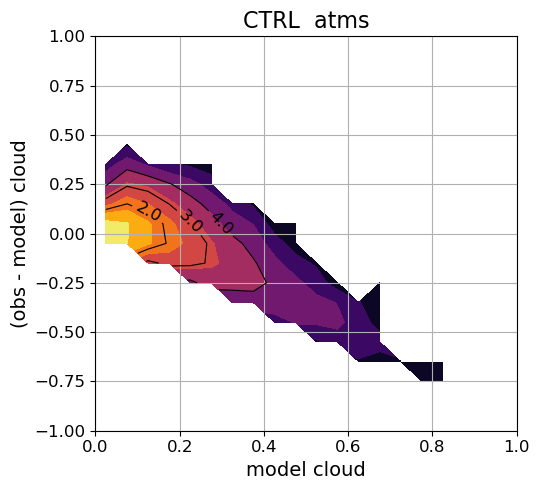

In [120]:
# model cloud vs OmF cloud

save_fig = True
fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/tables/{expid}/jointpdf_cloud_cloudomf'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

x_edges = np.linspace( 0, 1, 21)  
y_edges = np.linspace(-1, 1, 21)
dx = x_edges[1] - x_edges[0]
dy = y_edges[1] - y_edges[0]
dA = dx*dy

sym_cloud = 0.5*(dftmp['clw_bg_nobc_ges'] + dftmp['clw_obs'])

x = dftmp['clw_bg_nobc_ges']
y = dftmp['clw_obs'] - dftmp['clw_bg_nobc_ges']

hist, x_edges_out, y_edges_out = np.histogram2d(x, y, bins=[x_edges, y_edges], density=True)

xc = 0.5*(x_edges[:-1] + x_edges[1:])
yc = 0.5*(y_edges[:-1] + y_edges[1:])

xx, yy = np.meshgrid(xc, yc)

# Mask values >= 6
input_data = - np.log10(hist*dA)
input_data_mask = np.ma.masked_where(input_data >= 5.5, input_data)
input_data_mask = input_data

## Plot figure
fig, ax = plt.subplots(figsize=(5.5,5))
contour1=ax.contourf(xx, yy, -input_data_mask.T, cmap='inferno')

# Add contour lines
contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)

# Add labels to contour lines
ax.clabel(contour_lines, inline=True, fontsize=12, fmt="%.1f")

ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlabel('model cloud',fontsize=14)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_ylabel(f'(obs - model) cloud',fontsize=14)
ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)
ax.set_title(f'{expid_short[expid]}  {instrument}',fontsize=16)
plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/cloudomf_modelcloud_{instrument}_{expid}.png', dpi=200, bbox_inches='tight')

/tmp/ipykernel_2655291/2004722868.py:29: RuntimeWarning: divide by zero encountered in log10
  input_data = - np.log10(hist*dA)
/tmp/ipykernel_2655291/2004722868.py:38: RuntimeWarning: divide by zero encountered in log10
  contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)


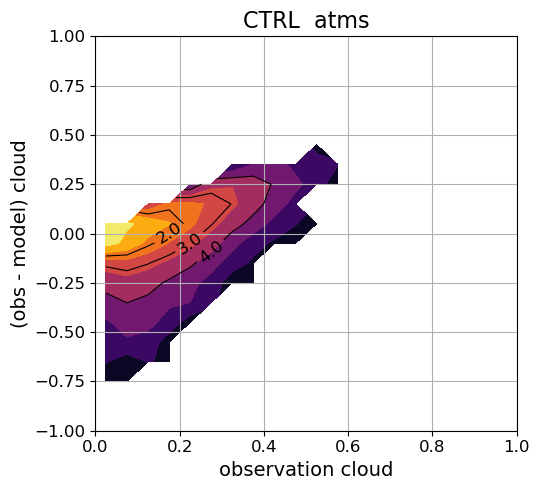

In [121]:
# obs cloud vs OmF cloud

save_fig = True
fig_dir = f'/home/Chih-Chi.Hu/python_codes/figures/tables/{expid}/jointpdf_cloud_cloudomf'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

x_edges = np.linspace( 0, 1, 21)  
y_edges = np.linspace(-1, 1, 21)
dx = x_edges[1] - x_edges[0]
dy = y_edges[1] - y_edges[0]
dA = dx*dy

sym_cloud = 0.5*(dftmp['clw_bg_nobc_ges'] + dftmp['clw_obs'])

x = dftmp['clw_obs']
y = dftmp['clw_obs'] - dftmp['clw_bg_nobc_ges']

hist, x_edges_out, y_edges_out = np.histogram2d(x, y, bins=[x_edges, y_edges], density=True)

xc = 0.5*(x_edges[:-1] + x_edges[1:])
yc = 0.5*(y_edges[:-1] + y_edges[1:])

xx, yy = np.meshgrid(xc, yc)

# Mask values >= 6
input_data = - np.log10(hist*dA)
input_data_mask = np.ma.masked_where(input_data >= 5.5, input_data)
input_data_mask = input_data

## Plot figure
fig, ax = plt.subplots(figsize=(5.5,5))
contour1=ax.contourf(xx, yy, -input_data_mask.T, cmap='inferno')

# Add contour lines
contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)

# Add labels to contour lines
ax.clabel(contour_lines, inline=True, fontsize=12, fmt="%.1f")

ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlabel('observation cloud',fontsize=14)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_ylabel(f'(obs - model) cloud',fontsize=14)
ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)
ax.set_title(f'{expid_short[expid]}  {instrument}',fontsize=16)
plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/cloudomf_obscloud_{instrument}_{expid}.png', dpi=200, bbox_inches='tight')

In [56]:
dx = x_edges[1] - x_edges[0] 
dy = y_edges[1] - y_edges[0] 

In [57]:
dx


0.02

In [58]:
dy

0.6000000000000014